# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
from dotenv import load_dotenv
import os

env_path = '../../data/.env'
load_dotenv(dotenv_path=env_path)

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
AQI_API_KEY = os.getenv("AQI_API_KEY")

In [ ]:
today = datetime.datetime.now() - datetime.timedelta(0)
today

datetime.datetime(2024, 11, 10, 14, 46, 51, 945268)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
project = hopsworks.login(project='mlfs_lab1')
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163420
2024-11-10 14:46:53,562 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
# feature_view = fs.get_feature_view(
#     name='air_quality_fv',
#     version=5,
# )

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=5,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='9.554791E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=4,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by=['date'], ascending=True, ignore_index=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_yesterday
0,2024-11-11 00:00:00+00:00,15.050000,0.0,9.673221,44.999897,shanghai,61.0
1,2024-11-12 00:00:00+00:00,15.200000,0.0,9.504272,52.695976,shanghai,NaN
2,2024-11-13 00:00:00+00:00,16.400000,0.0,11.013882,101.309898,shanghai,NaN
3,2024-11-14 00:00:00+00:00,20.750000,0.0,6.830519,108.435043,shanghai,NaN
4,2024-11-15 00:00:00+00:00,21.049999,0.0,8.049845,349.695221,shanghai,NaN
5,2024-11-16 00:00:00+00:00,16.600000,0.0,18.000000,360.000000,shanghai,NaN
6,2024-11-17 00:00:00+00:00,14.000000,0.0,18.218275,29.604366,shanghai,NaN
7,2024-11-18 00:00:00+00:00,14.400000,0.0,15.815435,48.691479,shanghai,NaN
8,2024-11-19 00:00:00+00:00,14.150000,0.0,13.004921,4.763556,shanghai,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', "pm25_yesterday"]])

batch_data['predicted_pm25'] = None
batch_data.at[0, 'predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data.iloc[[0]][['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'pm25_yesterday']]
)[0]

for i in range(1, len(batch_data)):
    batch_data.at[i, 'pm25_yesterday'] = batch_data.at[i-1, 'predicted_pm25']
    batch_data.at[i, 'predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data.iloc[[i]][['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'pm25_yesterday']]
    )[0]

batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_yesterday,predicted_pm25
0,2024-11-11 00:00:00+00:00,15.050000,0.0,9.673221,44.999897,shanghai,61.000000,94.719719
1,2024-11-12 00:00:00+00:00,15.200000,0.0,9.504272,52.695976,shanghai,94.719719,129.801376
2,2024-11-13 00:00:00+00:00,16.400000,0.0,11.013882,101.309898,shanghai,129.801376,105.657837
3,2024-11-14 00:00:00+00:00,20.750000,0.0,6.830519,108.435043,shanghai,105.657837,87.465858
4,2024-11-15 00:00:00+00:00,21.049999,0.0,8.049845,349.695221,shanghai,87.465858,106.330688
5,2024-11-16 00:00:00+00:00,16.600000,0.0,18.000000,360.000000,shanghai,106.330688,89.417862
6,2024-11-17 00:00:00+00:00,14.000000,0.0,18.218275,29.604366,shanghai,89.417862,98.805809
7,2024-11-18 00:00:00+00:00,14.400000,0.0,15.815435,48.691479,shanghai,98.805809,108.647614
8,2024-11-19 00:00:00+00:00,14.150000,0.0,13.004921,4.763556,shanghai,108.647614,154.126038


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_yesterday               9 non-null      float32            
 7   predicted_pm25               9 non-null      object             
dtypes: datetime64[us, UTC](1), float32(5), object(2)
memory usage: 528.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
# batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_yesterday,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-11 00:00:00+00:00,15.050000,0.0,9.673221,44.999897,shanghai,61.000000,94.719719,jinganjiancezhan,china,1
1,2024-11-12 00:00:00+00:00,15.200000,0.0,9.504272,52.695976,shanghai,94.719719,129.801376,jinganjiancezhan,china,2
2,2024-11-13 00:00:00+00:00,16.400000,0.0,11.013882,101.309898,shanghai,129.801376,105.657837,jinganjiancezhan,china,3
3,2024-11-14 00:00:00+00:00,20.750000,0.0,6.830519,108.435043,shanghai,105.657837,87.465858,jinganjiancezhan,china,4
4,2024-11-15 00:00:00+00:00,21.049999,0.0,8.049845,349.695221,shanghai,87.465858,106.330688,jinganjiancezhan,china,5
5,2024-11-16 00:00:00+00:00,16.600000,0.0,18.000000,360.000000,shanghai,106.330688,89.417862,jinganjiancezhan,china,6
6,2024-11-17 00:00:00+00:00,14.000000,0.0,18.218275,29.604366,shanghai,89.417862,98.805809,jinganjiancezhan,china,7
7,2024-11-18 00:00:00+00:00,14.400000,0.0,15.815435,48.691479,shanghai,98.805809,108.647614,jinganjiancezhan,china,8
8,2024-11-19 00:00:00+00:00,14.150000,0.0,13.004921,4.763556,shanghai,108.647614,154.126038,jinganjiancezhan,china,9


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_yesterday               9 non-null      float32            
 7   predicted_pm25               9 non-null      object             
 8   street                       9 non-null      object             
 9   country                      9 non-null      object             
 10  days_before_forecast_day     9 non-null      int64    

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-10 14:47:03,083 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



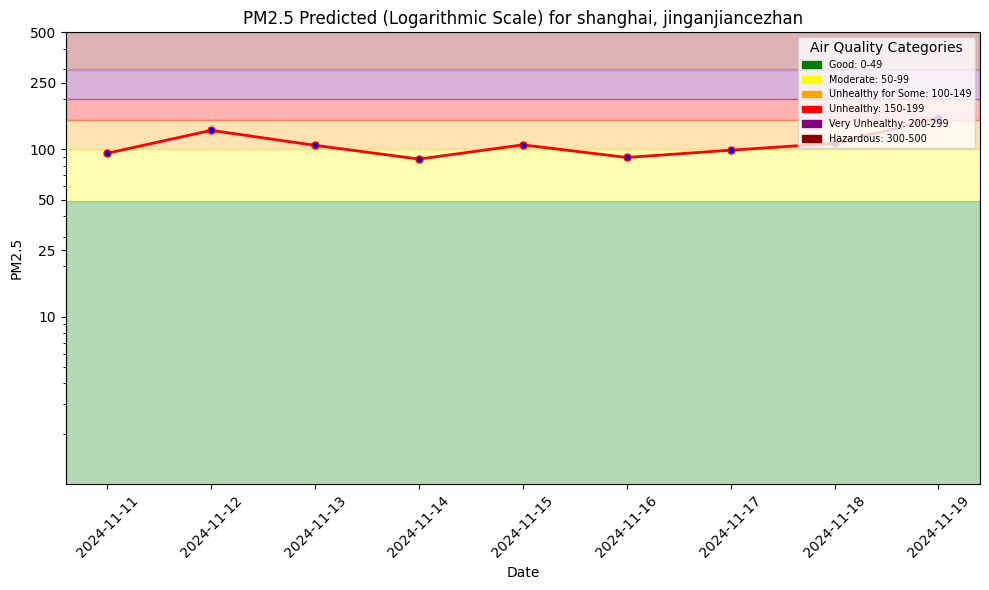

In [12]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=3,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})
# temp = monitor_fg.read().sort_values(by=['date'], ascending=True)
# temp

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.87s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_yesterday,predicted_pm25,street,country,days_before_forecast_day
9,2024-11-10 00:00:00+00:00,16.150000,0.0,12.261158,3.366400,shanghai,43.000000,71.452209,jinganjiancezhan,china,1
8,2024-11-11 00:00:00+00:00,15.050000,0.0,9.673221,44.999897,shanghai,61.000000,94.719719,jinganjiancezhan,china,1
4,2024-11-12 00:00:00+00:00,15.200000,0.0,9.504272,52.695976,shanghai,94.719719,129.801376,jinganjiancezhan,china,2
3,2024-11-13 00:00:00+00:00,16.400000,0.0,11.013882,101.309898,shanghai,129.801376,105.657837,jinganjiancezhan,china,3
2,2024-11-14 00:00:00+00:00,20.750000,0.0,6.830519,108.435043,shanghai,105.657837,87.465858,jinganjiancezhan,china,4
7,2024-11-15 00:00:00+00:00,21.049999,0.0,8.049845,349.695221,shanghai,87.465858,106.330688,jinganjiancezhan,china,5
6,2024-11-16 00:00:00+00:00,16.600000,0.0,18.000000,360.000000,shanghai,106.330688,89.417862,jinganjiancezhan,china,6
5,2024-11-17 00:00:00+00:00,14.000000,0.0,18.218275,29.604366,shanghai,89.417862,98.805809,jinganjiancezhan,china,7
1,2024-11-18 00:00:00+00:00,14.400000,0.0,15.815435,48.691479,shanghai,98.805809,108.647614,jinganjiancezhan,china,8
0,2024-11-19 00:00:00+00:00,14.150000,0.0,13.004921,4.763556,shanghai,108.647614,154.126038,jinganjiancezhan,china,9


In [19]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_yesterday,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-11 00:00:00+00:00,15.05,0.0,9.673221,44.999897,shanghai,61.0,94.719719,jinganjiancezhan,china,1
1,2024-11-10 00:00:00+00:00,16.15,0.0,12.261158,3.366400,shanghai,43.0,71.452209,jinganjiancezhan,china,1


In [16]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
air_quality_df = air_quality_fg.read()
air_quality_df

temp = air_quality_fg.read().sort_values(by=['date'], ascending=True).tail(10)
temp

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.41s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 


,date,pm25,country,city,street,url
3790,2024-11-01 00:00:00+00:00,20.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3721,2024-11-02 00:00:00+00:00,103.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
708,2024-11-03 00:00:00+00:00,140.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
540,2024-11-04 00:00:00+00:00,124.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
348,2024-11-05 00:00:00+00:00,45.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
1286,2024-11-06 00:00:00+00:00,35.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
1370,2024-11-07 00:00:00+00:00,35.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3120,2024-11-08 00:00:00+00:00,55.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
2555,2024-11-09 00:00:00+00:00,43.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3951,2024-11-10 00:00:00+00:00,61.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486


In [20]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-10 00:00:00+00:00,71.452209,61.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

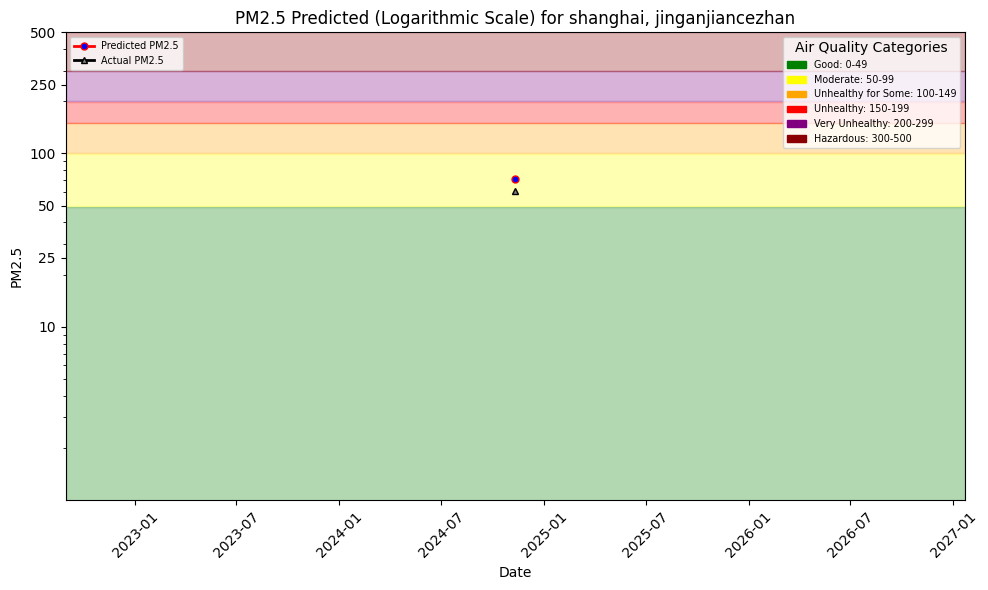

In [21]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---